In [1]:
import os
import sys
sys.path.append('/homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman')
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy.integrate import odeint
from model_aug_koopman import Aug_Koopman_Model, Multi_INT_net, get_initial_condition
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random
from sklearn.random_projection import sparse_random_matrix

import pickle
import numpy as np
file_name_results = 'VDP_oscillator_HankelEDMD'
output_file_folder = '/homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman/Identification/Models_And_Outputs/' + file_name_results +'/'
try:
    os.makedirs(output_file_folder)    
    print("Directory " , output_file_folder ,  " Created ")
except FileExistsError:
    print("Directory " , output_file_folder ,  " already exists, overwriting results")  


Directory  /homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman/Identification/Models_And_Outputs/VDP_oscillator_HankelEDMD/  Created 


In [2]:
def VDP_O(S,t,mu):
    """ VDP dynamical model. """
    x_1 = (S[1]);
    x_2 = mu*(1-S[0]**2)*S[1] -S[0];
    dS  = np.array([x_1,x_2]);
    return dS

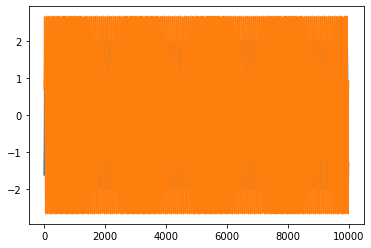

In [3]:
dt_integration = dt = 0.1
mu = 1.0

tf = 1000

x0 = np.array([5.0,1.0]);
S = odeint(VDP_O,x0,np.arange(0,tf+0.000001,dt_integration),args=(mu,));
x0 = S[-1,:]
S = odeint(VDP_O,x0,np.arange(0.1,tf+0.000001,dt_integration),args=(mu,));
plt.plot(S[:])
dim = 2
X_train = S[500:5500,:]
X_test  = S[5500:,:]

In [4]:
# Embedding parameters
params = {}
params['length_embed'] = 50
params['delay_embed']  = 1

In [5]:
H = X_train.T[:,params['delay_embed']:-(params['length_embed']*params['delay_embed'])+params['delay_embed']]
for i in range(2,params['length_embed']):
    H = np.concatenate((H,X_train.T[:,i*params['delay_embed']:-(params['length_embed']*params['delay_embed'])+i*params['delay_embed']]))
H = np.concatenate((H,X_train.T[:,params['length_embed']*params['delay_embed']:]))

In [6]:
HT = X_test.T[:,params['delay_embed']:-(params['length_embed']*params['delay_embed'])+params['delay_embed']]
for i in range(2,params['length_embed']):
    HT = np.concatenate((HT,X_test.T[:,i*params['delay_embed']:-(params['length_embed']*params['delay_embed'])+i*params['delay_embed']]))
HT = np.concatenate((HT,X_test.T[:,params['length_embed']*params['delay_embed']:]))

In [7]:
svd = TruncatedSVD(n_components=16, n_iter=7, random_state=42)
v = svd.fit_transform(H.T)
Train_X_EDMD = v[:-1,:]
Train_Y_EDMD = v[1:,:]
A_EDMD  = np.dot(np.linalg.pinv(Train_X_EDMD[:,:]),Train_Y_EDMD[:,:]).T

In [8]:
pred_EDMD = np.zeros((X_test.shape[0],Train_Y_EDMD.shape[-1]))# np.zeros_like(X_test)
v_init = svd.transform(HT.T)
pred_EDMD[:1,:] = v_init[:1,:]#Train_Y_EDMD[-1:,:]# 
for i in range(X_test.shape[0]-1):
    pred_EDMD[i+1,:] = np.dot(A_EDMD,pred_EDMD[i,:].T).T
pred_EDMD_VDP = svd.inverse_transform(pred_EDMD)

In [9]:
X_test_shifted = X_test[params['length_embed']:,:]
y_pred = pred_EDMD_VDP[:,-dim:]

In [10]:
out_res = {}
out_res['train_data'] = X_train
out_res['test_data']  = X_test_shifted[:3000]
out_res['dt']         = dt
out_res['infered_test']  =y_pred[:3000]

pickle_out = open(output_file_folder+file_name_results+".pkl","wb")
pickle.dump(out_res, pickle_out)
pickle_out.close()

In [11]:
file_to_read = open(output_file_folder+file_name_results+".pkl", "rb")
res = pickle.load(file_to_read)

In [12]:
def R_C_E(y_true, y_pred): 
    return (np.sum((y_true - (y_pred))**2)/ np.sum(y_true**2)) *100
idx = 0
test_batch = res['test_data'][:,:]
pred_batch = res['infered_test']

In [13]:
print('error first 1000 samples: ', R_C_E(test_batch[:1000,:],pred_batch[:1000,:]))
print('error second 1000 samples: ', R_C_E(test_batch[1000:2000,:],pred_batch[1000:2000,:]))
print('error third 1000 samples: ', R_C_E(test_batch[2000:3000,:],pred_batch[2000:3000,:]))

error first 1000 samples:  1.3522991629254092e-06
error second 1000 samples:  5.991207155011528e-06
error third 1000 samples:  1.0512452714768378e-05


Text(0, 0.5, '${\\mathrm{z}}_{2,t}$')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


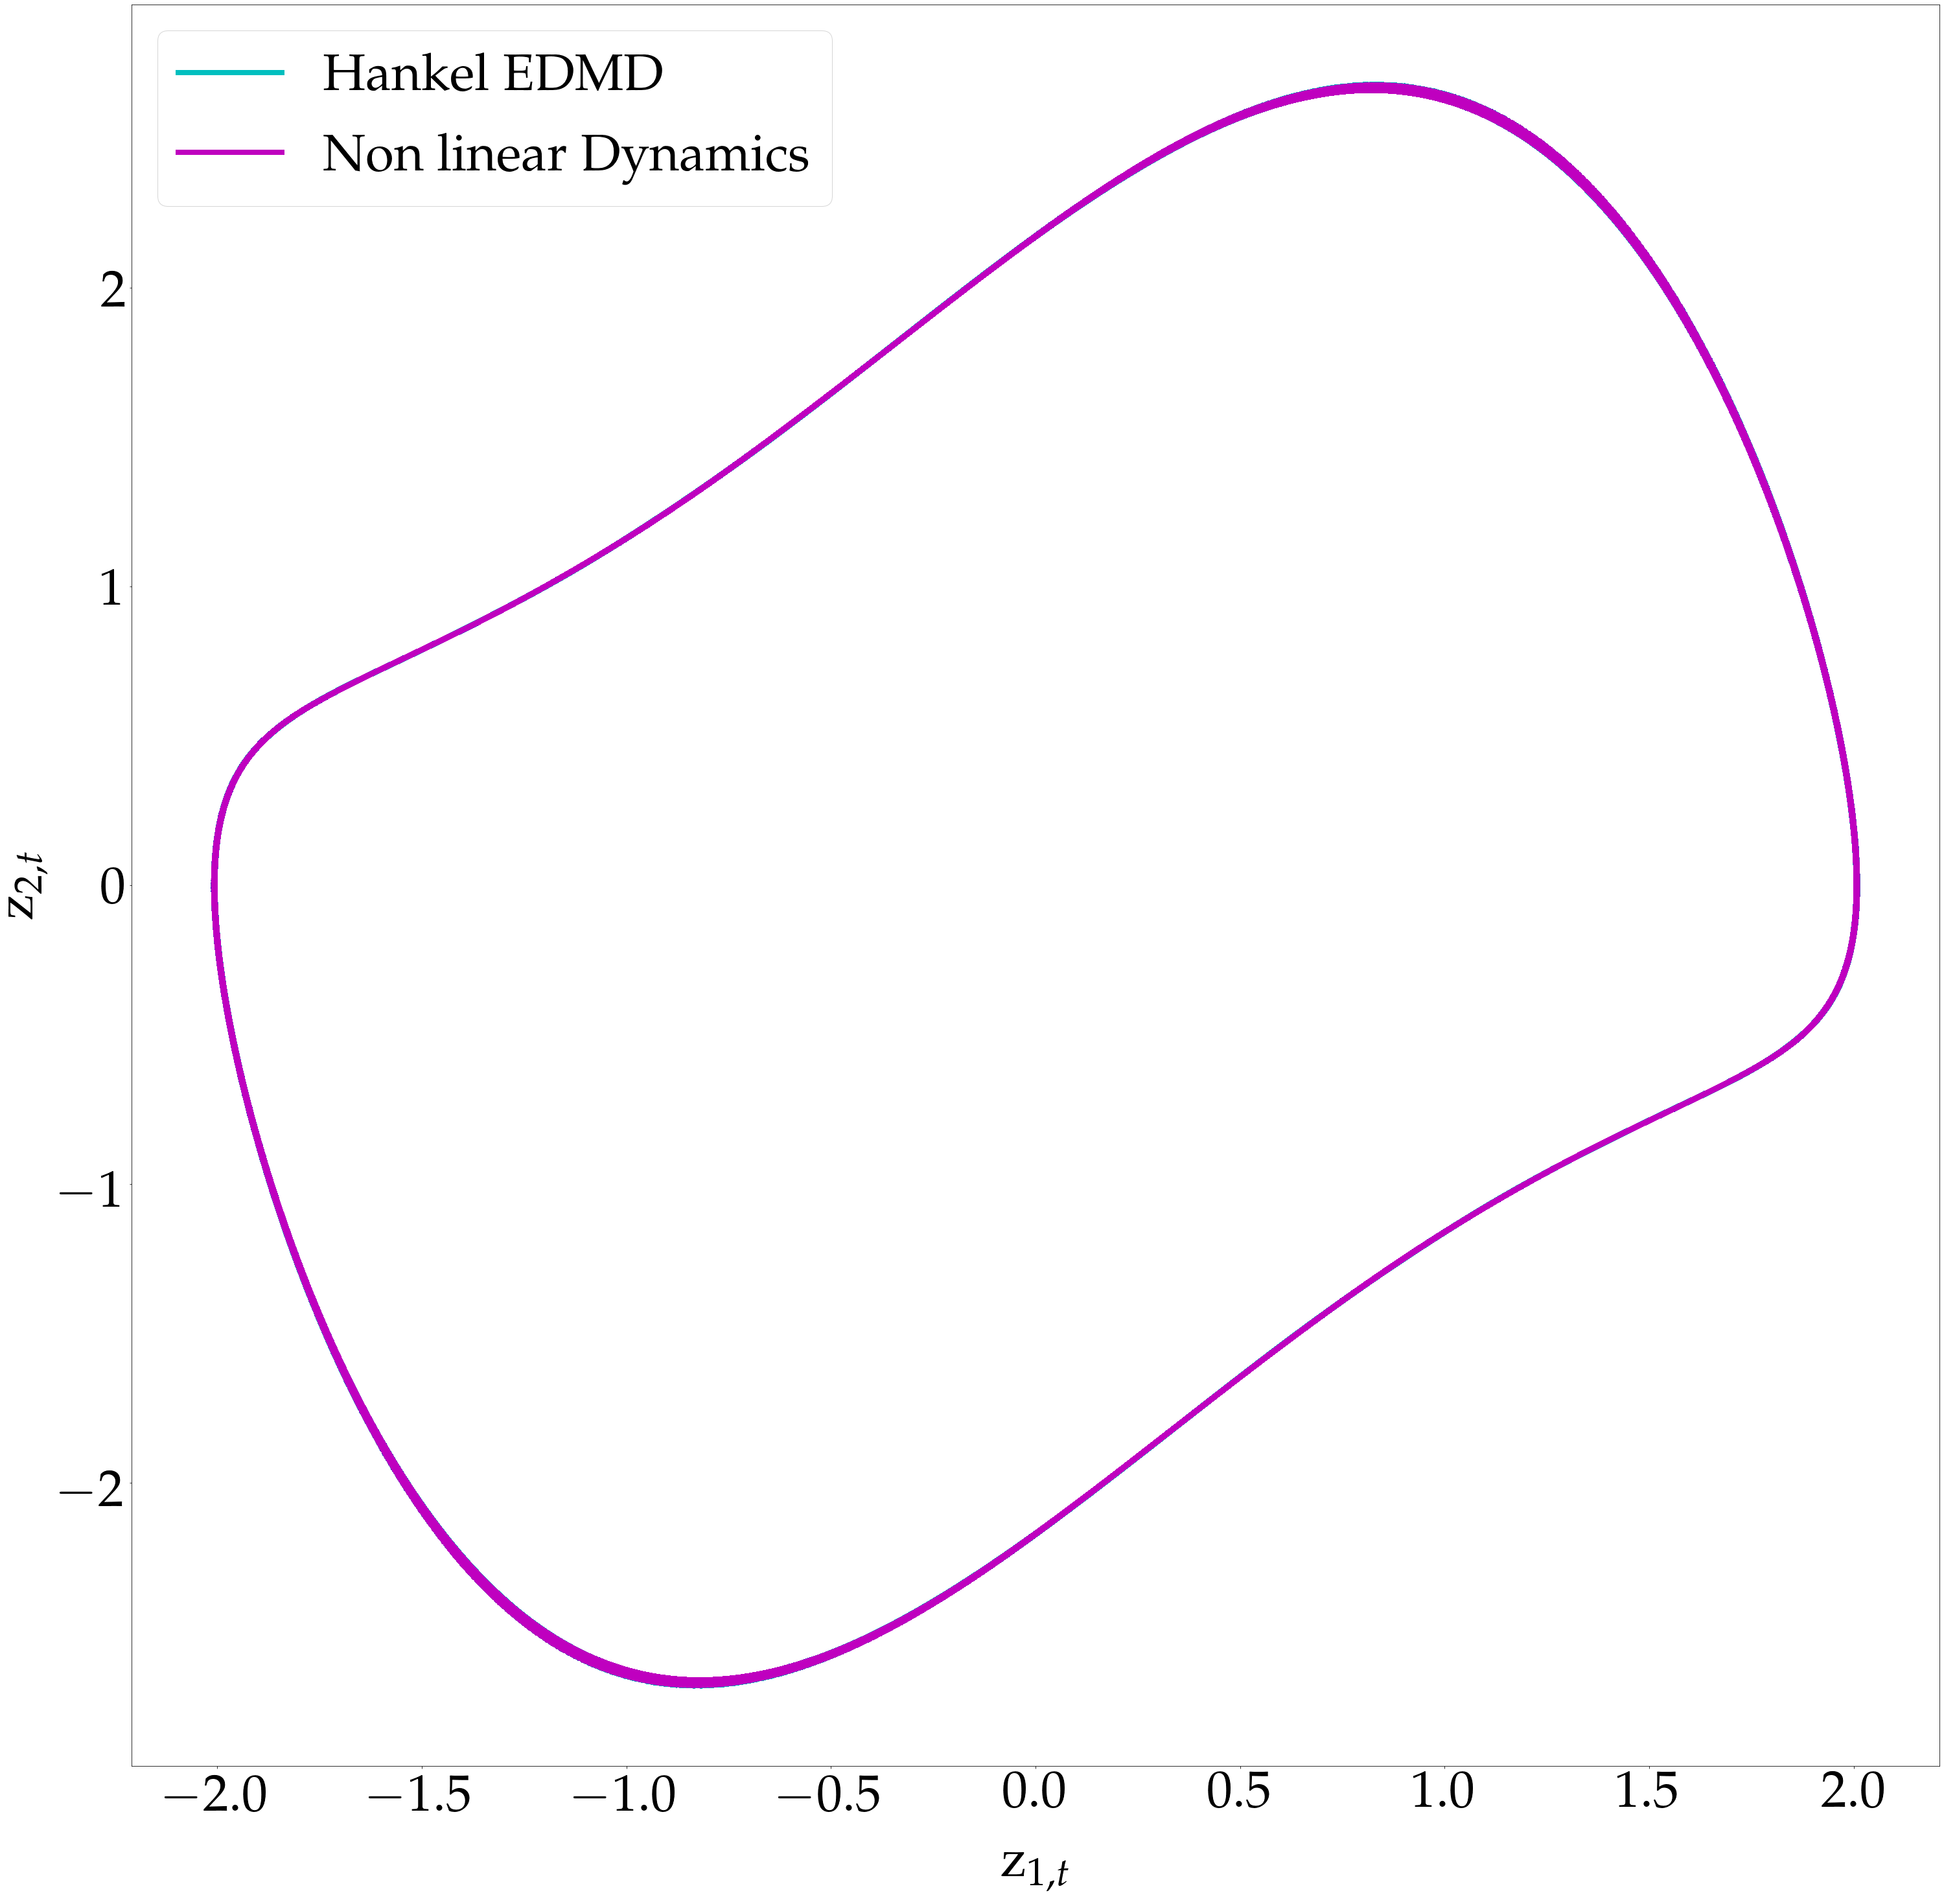

In [14]:
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 80})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
fig=plt.figure(figsize=(50,50))
for i in range(0,len(res['test_data'])):
        plt.plot(res['infered_test'][:2000,0],res['infered_test'][:2000,1],c = 'c',lw = 8)
        plt.plot(res['test_data'][:2000,0],res['test_data'][:2000,1],c = 'm',lw = 8)

plt.plot(res['infered_test'][:2000,0]*np.nan,res['infered_test'][:2000,0]*np.nan,c = 'c',lw = 8,label = 'Hankel EDMD')
plt.plot(res['test_data'][:2000,0]*np.nan,res['test_data'][:2000,0]*np.nan,c = 'm',lw = 8,label = 'Non linear Dynamics')
plt.legend()
plt.xlabel('${\mathrm{z}}_{1,t}$',labelpad = 40)
plt.ylabel('${\mathrm{z}}_{2,t}$')

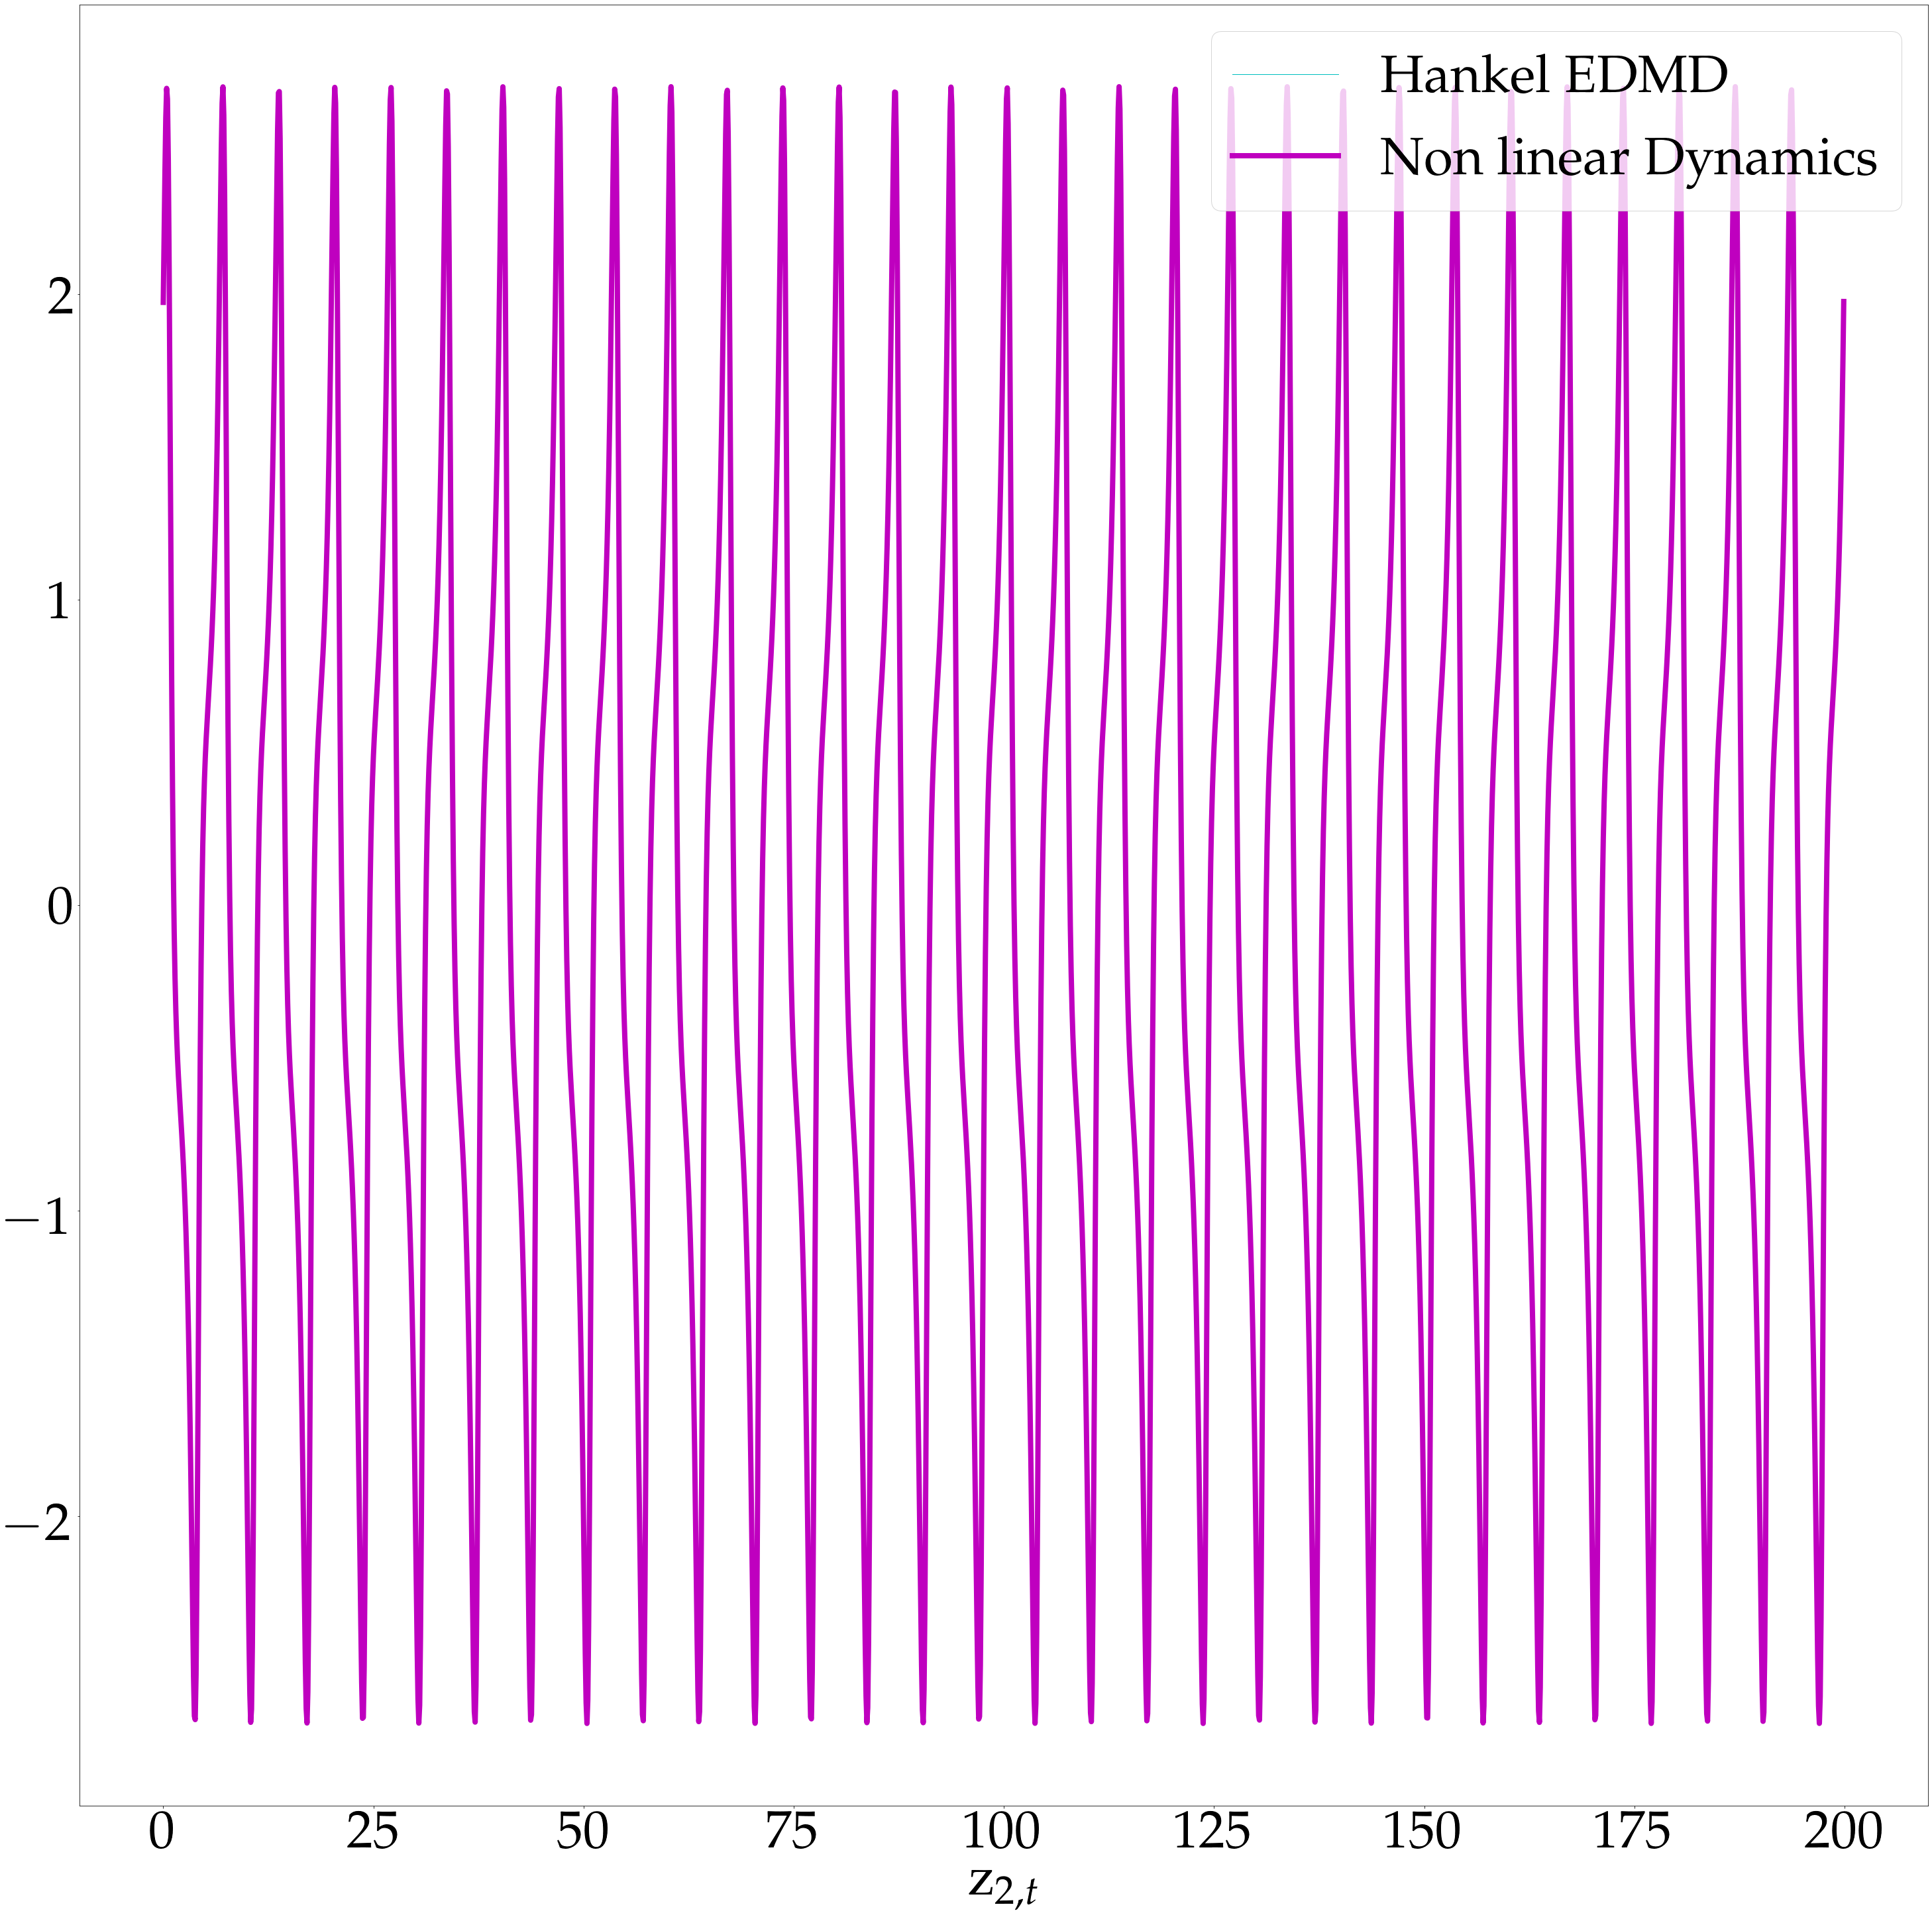

In [15]:
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 80})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
fig=plt.figure(figsize=(50,50))


idx = 126
plt.plot(np.linspace(0,2000*0.1-0.1,2000),res['infered_test'][idx:2000+idx,1],c = 'c',lw = 1,label = 'Hankel EDMD')
plt.plot(np.linspace(0,2000*0.1-0.1,2000),res['test_data'][idx:2000+idx,1],c = 'm',lw = 8,label = 'Non linear Dynamics')
plt.xlabel('Time')
plt.xlabel('${\mathrm{z}}_{2,t}$')
plt.legend()